# SNP filtering using vcftools   


use preferred conda env  
**Packages needed**: vcftools, bgzip, tabix

### Things we filter on:  

#### Individuals:  
- **Coverage**: Also can be thought of as **depth**.See 3mapping. Calculated on bam files. Average read count per locus per individual. 
- **Missing**: Proportion of missing data allowed across all loci for individual. Common and high in GBS/RADseq data. Kinda an issue all around. Many methods, including PCA (all ordination methods), require a complete matrix with no missing data. Additionally, PCA will cluster by missing data with individuals with higher missing data clustering closer to the center and get this "fan" effect. Can be the same for coverage too. This (among other reasons) is why people use a variance-covariance matrix of genetic data to do ordinations. Other methods involve imputation. This can be fancy and use phased haplotype data OR simply, when you z-score, (g - mean(g))/sd(g), your genotype data across each locus, you make all missing data equal to 0 or Mean (i.e., the global allele frequency). There's more to this standardization, see *Patterson et al. 2006* (https://dx.plos.org/10.1371/journal.pgen.0020190) for more info. See PCAsim_ex in examples directory for showing all these issues.
    - (additional) This is another reason to use entropy. Entropy is a hierarchical bayesian model so it gets an updated genotype estimate for each missing value based on genotype likelihoods across loci, individuals, and the allele frequency of the cluster/deme that individual assigns to.   
    
#### Loci:  
- **Biallelic**: Only keep biallelic SNPs. Multiallelic SNPs are rare at the time scale we work (Citation??) and also,  mathematical nightmare and we have enough data so just ignore. Everyone does unless deep time phylogenetics. 
- **thin**: Keeps one locus within a specified range. Not 100% how it decides with one to keep. I think it's on quality or depth. This is a necessary step as loci in close physical are prone to sequencing error and linkage disequalibrium (LD) confounds many different population genetic parameters. For *de novo* reference assemblies, we thin to 100 as contigs/reads are ~92 bp in length. This keeps one locus per contig to control for LD and sequencing error, which is really common in pop gen and necessary for many analyses.   
- **max-missing** = max proportion of missing data per locus  
- **MAF** = minor allele frequency. Proportion of individuals a alternate allele needs to be present in order for that locus to be kept as a SNP. (e.g. maf = 0.02 for 250 individuals means that an alternate allele needs to be present in at least 5 individuals to be kept) Many papers have shown this is a big issue in clustering and demography (Citation). We do this a second time near the end if we removed individuals during missing data filtering.   
- **Mean Depth**: Average allelic depth or read depth per locus. Too low could be sequencing error, too high could be PCR replication artifact (Citation).    
- **Qual**: Locus Quality. You can look up the math. Usually above 20-30 is good but given our coverage and number of individuals, we can usually go way higher.     
- **Fis**: Inbreeding coefficient. This is a contentous topic. This has to do with paralogs or paralogous loci. This is where loci map to multiple regions of the genome. Issues in highly repeative genomes. Usually leads to an excess of heterozygotes. Filtering on negative Fis can help. See these two McKinney papers (https://onlinelibrary.wiley.com/doi/10.1111/1755-0998.12763, https://onlinelibrary.wiley.com/doi/abs/10.1111/1755-0998.12613). Katie and others in the lab use his package called HDPlot to deal with this.   


**See methods_ex.Rmd in examples directory for text** 


In [12]:
import sys
import ipyparallel as ipp
import os
from os import environ
import gzip
import warnings
import pandas as pd
import numpy as np
import scipy as sp
import glob
import re
import random

In [13]:
vcftools = "vcftools"
bgzip = "bgzip"
tabix = "tabix"

In [14]:
root = '/data/gpfs/assoc/denovo/PHHA/SNPcall/'

In [15]:
cd $root

/data/gpfs/assoc/denovo/PHHA/SNPcall


#### cp vcf.gz from vcf_dir to filtering

In [5]:
!mkdir filtering

In [6]:
!cp vcf/PHHA.vcf.gz filtering/

In [16]:
analysis_dir = os.path.join(root,"filtering")

In [17]:
cd $analysis_dir

/data/gpfs/assoc/denovo/PHHA/SNPcall/filtering


#### count snps in zipped vcf 

In [21]:
vcf_file = os.path.join(analysis_dir, "PHHA.vcf.gz")
assert os.path.exists(vcf_file)
vcf_file

'/data/gpfs/assoc/denovo/PHHA/SNPcall/filtering/PHHA.vcf.gz'

In [22]:
!zcat $vcf_file | grep -v '#' | wc -l 

^C


## keep only biallelic loci as first step

In [23]:
!$vcftools --remove-indels \
--min-alleles 2 \
--max-alleles 2 \
--remove-filtered-all \
--recode \
--recode-INFO-all \
--gzvcf \
$vcf_file \
--out $'PHHA.biallelic'


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/PHHA/SNPcall/filtering/PHHA.vcf.gz
	--recode-INFO-all
	--max-alleles 2
	--min-alleles 2
	--out PHHA.biallelic
	--recode
	--remove-filtered-all
	--remove-indels

Using zlib version: 1.2.11
After filtering, kept 248 out of 248 Individuals
Outputting VCF file...
After filtering, kept 1334848 out of a possible 1582788 Sites
Run Time = 657.00 seconds


In [24]:
vcf_biallelic = os.path.join(analysis_dir, "PHHA.biallelic.recode.vcf")
vcf_biallelic_gz = vcf_biallelic + '.gz'
!$bgzip -c $vcf_biallelic > {vcf_biallelic_gz}
!$tabix {vcf_biallelic_gz}

## Remove by MAF, missing data, and thin   


In [25]:
!$vcftools \
--max-missing 0.6 \
--maf 0.02 \
--thin 100 \
--remove-filtered-all \
--recode \
--recode-INFO-all \
--gzvcf \
$vcf_biallelic_gz \
--out $'PHHA_miss60_thin100_MAF2'


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/PHHA/SNPcall/filtering/PHHA.biallelic.recode.vcf.gz
	--recode-INFO-all
	--maf 0.02
	--thin 100
	--max-missing 0.6
	--out PHHA_miss60_thin100_MAF2
	--recode
	--remove-filtered-all

Using zlib version: 1.2.11
After filtering, kept 248 out of 248 Individuals
Outputting VCF file...
After filtering, kept 42386 out of a possible 1334848 Sites
Run Time = 79.00 seconds


In [26]:
!$vcftools \
--max-missing 0.7 \
--maf 0.02 \
--thin 100 \
--remove-filtered-all \
--recode \
--recode-INFO-all \
--gzvcf \
$vcf_biallelic_gz \
--out $'PHHA_miss70_thin100_MAF2'


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/PHHA/SNPcall/filtering/PHHA.biallelic.recode.vcf.gz
	--recode-INFO-all
	--maf 0.02
	--thin 100
	--max-missing 0.7
	--out PHHA_miss70_thin100_MAF2
	--recode
	--remove-filtered-all

Using zlib version: 1.2.11
After filtering, kept 248 out of 248 Individuals
Outputting VCF file...
After filtering, kept 34737 out of a possible 1334848 Sites
Run Time = 75.00 seconds


In [27]:
vcf_filtered = "PHHA_miss70_thin100_MAF2.recode.vcf"
vcf_filtered_gz = "%s.gz" % vcf_filtered

In [28]:
!$bgzip -c $vcf_filtered > {vcf_filtered_gz}
!$tabix {vcf_filtered_gz}

# Remove individuals with too much missing data (bad_indv)


In [29]:
!$vcftools --gzvcf $vcf_filtered_gz --out $vcf_filtered_gz --missing-indv


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf PHHA_miss70_thin100_MAF2.recode.vcf.gz
	--missing-indv
	--out PHHA_miss70_thin100_MAF2.recode.vcf.gz

Using zlib version: 1.2.11
After filtering, kept 248 out of 248 Individuals
Outputting Individual Missingness
After filtering, kept 34737 out of a possible 34737 Sites
Run Time = 2.00 seconds


In [30]:
def get_imiss(vcf_file):
    imiss_file = !ls {vcf_file}.imiss
    imiss_df = pd.read_csv(imiss_file[0], sep="\t")
    imiss_df.index = imiss_df.INDV
    return imiss_df

In [31]:
imiss_df = get_imiss(vcf_filtered_gz)
imiss_df.head()

,INDV,N_DATA,N_GENOTYPES_FILTERED,N_MISS,F_MISS
INDV,,,,,
PH_AS_10,PH_AS_10,34737,0,1467,0.042232
PH_AS_11,PH_AS_11,34737,0,3811,0.109710
PH_AS_12,PH_AS_12,34737,0,2870,0.082621
PH_AS_1,PH_AS_1,34737,0,3023,0.087025
PH_AS_2,PH_AS_2,34737,0,874,0.025160


In [32]:
imiss_df.F_MISS.describe()

count    248.000000
mean       0.125917
std        0.088792
min        0.015833
25%        0.079800
50%        0.098944
75%        0.158412
max        0.989953
Name: F_MISS, dtype: float64

#### Below is just allows you to input a cutoff and see how many individuals you lose, keeping individuals with at least 60% data

In [34]:
len(imiss_df),len(imiss_df[imiss_df.F_MISS >= .4]),len(imiss_df[imiss_df.F_MISS >= .5]), len(imiss_df[imiss_df.F_MISS >= .25])


(248, 3, 1, 14)

In [35]:
bad_indv = imiss_df.INDV[imiss_df.F_MISS >= .4]

In [36]:
with open(os.path.join(analysis_dir, "bad_indv.txt"), "w") as o:
    o.write("INDV\n")
    for elem in bad_indv.index:
        o.write("%s\n" % elem)

In [37]:
!$vcftools --gzvcf $vcf_filtered_gz \
--remove-indels  \
--remove-filtered-all \
--recode \
--recode-INFO-all \
--remove {os.path.join(analysis_dir, "bad_indv.txt")} \
--out {os.path.join(analysis_dir, "snps_indv_removed")}


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf PHHA_miss70_thin100_MAF2.recode.vcf.gz
	--remove /data/gpfs/assoc/denovo/PHHA/SNPcall/filtering/bad_indv.txt
	--recode-INFO-all
	--out /data/gpfs/assoc/denovo/PHHA/SNPcall/filtering/snps_indv_removed
	--recode
	--remove-filtered-all
	--remove-indels

Using zlib version: 1.2.11
Excluding individuals in 'exclude' list
After filtering, kept 245 out of 248 Individuals
Outputting VCF file...
After filtering, kept 34737 out of a possible 34737 Sites
Run Time = 18.00 seconds


In [38]:
vcf_bad_remove = os.path.join(analysis_dir, "snps_indv_removed.recode.vcf")
vcf_bad_remove_gz = vcf_bad_remove + ".gz"
!$bgzip -c {vcf_bad_remove} > {vcf_bad_remove_gz}
!$tabix {vcf_bad_remove_gz}

# Filter snps further 
this needs to be done after removing individuals   

### This uses vcftools to get some stats to summarize and make decisions with later

In [39]:
def get_vcf_stats(vcf_gz):
    
    stats = ['depth',
            'site-depth',
            'site-mean-depth',
            'site-quality',
            'missing-site',
            'freq',
            'counts',
            'hardy',
            'het']
    
    for stat in stats:
        !$vcftools --gzvcf $vcf_gz \
        --out $vcf_gz \
        {"--%s" % stat} 

In [40]:
get_vcf_stats(vcf_bad_remove_gz)


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/PHHA/SNPcall/filtering/snps_indv_removed.recode.vcf.gz
	--depth
	--out /data/gpfs/assoc/denovo/PHHA/SNPcall/filtering/snps_indv_removed.recode.vcf.gz

Using zlib version: 1.2.11
After filtering, kept 245 out of 245 Individuals
Outputting Mean Depth by Individual
After filtering, kept 34737 out of a possible 34737 Sites
Run Time = 2.00 seconds

VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/PHHA/SNPcall/filtering/snps_indv_removed.recode.vcf.gz
	--out /data/gpfs/assoc/denovo/PHHA/SNPcall/filtering/snps_indv_removed.recode.vcf.gz
	--site-depth

Using zlib version: 1.2.11
After filtering, kept 245 out of 245 Individuals
Outputting Depth for Each Site
After filtering, kept 34737 out of a possible 34737 Sites
Run Time = 3.00 seconds

VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Para

After filtering, kept 245 out of 245 Individuals
Outputting Individual Heterozygosity
After filtering, kept 34737 out of a possible 34737 Sites
Run Time = 2.00 seconds


### Functions that will calculate various metrics we use to filter   

In [41]:
#pd.set_option('display.max_columns', 100)

def get_MAF(row):
    try:
        return np.min([row.A1_freq, row.A2_freq])
    except:
        print(row)
        
def get_correction(n):
    #for finite sample size
    return (2*n)/(2*n-1)

def calculate_Fis(vals):
    try:
        data = [float(x) for x in vals.split("/")]
        assert len(data) == 3
        num_individuals = np.sum(data)
        total_alleles = 2*num_individuals
        a1_count = 2*data[0]
        a2_count = 2*data[2]
        het_count = data[1]
        a1_count += het_count
        a2_count += het_count
        a1_freq = a1_count/total_alleles
        a2_freq = a2_count/total_alleles
        assert a1_freq + a2_freq == 1.0
        He = 2 * a1_freq * a2_freq * get_correction(num_individuals)
        Ho = het_count/num_individuals
        Fis = 1 - (Ho/He)
        return Fis
    except:
        return -9

def combine_vcf_stats(filedir, prefix):
    
    hardy_files = !ls {filedir}/{prefix}.hwe
    hardy = pd.read_csv(hardy_files[0], sep="\t")

    hardy.columns = ['CHROM', 'POS', 'OBS(HOM1/HET/HOM2)', 'E(HOM1/HET/HOM2)', 'ChiSq_HWE',
       'P_HWE', 'P_HET_DEFICIT', 'P_HET_EXCESS']
    hardy.index = hardy.apply(lambda x: "%s-%d" % (x.CHROM, x.POS), axis=1)
    
    loci_files = !ls {filedir}/{prefix}.l* | grep -v log
    loci_df = pd.concat([pd.read_csv(x, sep="\t", skiprows=0) for x in loci_files], axis=1)
    chrom_pos = loci_df.ix[:,0:2]
    
    frq_files = !ls {filedir}/{prefix}.frq* | grep -v count
    frq_data = []
    h = open(frq_files[0])
    header = h.readline().strip().split()
    for line in h:
        frq_data.append(line.strip().split('\t'))

    header = ['CHROM', 'POS', 'N_ALLELES', 'N_CHR', 'A1_FREQ', "A2_FREQ"]
    frq_df = pd.DataFrame(frq_data)
    print(frq_df.columns)
    #frq_df = frq_df.drop([6,7],axis=1)
    frq_df.columns = header
    frq_df.index = frq_df.apply(lambda x: "%s-%s" % (x.CHROM, x.POS), axis=1)
    
    loci_df = loci_df.drop(['CHROM','CHR','POS'], axis=1)
    loci_df = pd.concat([chrom_pos, loci_df], axis=1)
    loci_df.index = loci_df.apply(lambda x: "%s-%d" % (x.CHROM, x.POS), axis=1)
    
    loci_df = pd.concat([loci_df, frq_df, hardy], axis=1)
    loci_df["A1_allele"] = loci_df.apply(lambda row: row.A1_FREQ.split(":")[0], axis=1)
    loci_df["A2_allele"] = loci_df.apply(lambda row: row.A2_FREQ.split(":")[0], axis=1)
    
    loci_df["A1_freq"] = loci_df.apply(lambda row: float(row.A1_FREQ.split(":")[1]), axis=1)
    loci_df["A2_freq"] = loci_df.apply(lambda row: float(row.A2_FREQ.split(":")[1]), axis=1)
    
    loci_df['MAF'] = loci_df.apply(get_MAF, axis=1)
    loci_df = loci_df.drop(['CHROM', 'POS'], axis=1)
    
    loci_df['Fis'] = loci_df['OBS(HOM1/HET/HOM2)'].apply(calculate_Fis)
    
    return loci_df, frq_df, hardy

In [42]:
vcf_bad_remove_gz

'/data/gpfs/assoc/denovo/PHHA/SNPcall/filtering/snps_indv_removed.recode.vcf.gz'

In [43]:
loci_df, frq_df, hardy = combine_vcf_stats(analysis_dir,'snps_indv_removed.recode.vcf.gz')

/data/gpfs/assoc/parchmanlab/tfaske/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
/data/gpfs/assoc/parchmanlab/tfaske/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:822: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  retval = getattr(retval, self.name)._getitem_axis(key, axis=i)


RangeIndex(start=0, stop=6, step=1)


In [44]:
loci_df.head()

,SUM_DEPTH,SUMSQ_DEPTH,MEAN_DEPTH,VAR_DEPTH,N_DATA,N_GENOTYPE_FILTERED,N_MISS,F_MISS,QUAL,N_ALLELES,...,ChiSq_HWE,P_HWE,P_HET_DEFICIT,P_HET_EXCESS,A1_allele,A2_allele,A1_freq,A2_freq,MAF,Fis
dDocent_Contig_23-44,13650,1167216,55.71430,1666.87000,490,0,6,0.012245,507.0,2,...,0.497843,1.000000e+00,1.000000e+00,0.635577,T,C,0.956612,0.043388,0.043388,-0.043197
dDocent_Contig_27-26,603,2977,2.46122,6.11837,490,0,114,0.232653,359.0,2,...,1.517900,6.176162e-01,1.000000e+00,0.259856,T,A,0.917553,0.082447,0.082447,-0.086957
dDocent_Contig_103-30,59707,14552605,243.70200,7.73463,490,0,0,0.000000,977.0,2,...,245.000000,3.521762e-11,3.521762e-11,1.000000,A,C,0.979592,0.020408,0.020408,1.000000
dDocent_Contig_148-62,60976,15176182,248.88200,1.53921,490,0,0,0.000000,999.0,2,...,213.330700,2.172593e-22,2.172593e-22,1.000000,C,A,0.934694,0.065306,0.065306,0.933270
dDocent_Contig_152-75,58538,13991770,238.93100,21.51570,490,0,0,0.000000,999.0,2,...,229.337900,9.782448e-25,9.782448e-25,1.000000,T,G,0.932653,0.067347,0.067347,0.967575


In [45]:
frq_df.head()

,CHROM,POS,N_ALLELES,N_CHR,A1_FREQ,A2_FREQ
dDocent_Contig_23-44,dDocent_Contig_23,44,2,484,T:0.956612,C:0.0433884
dDocent_Contig_27-26,dDocent_Contig_27,26,2,376,T:0.917553,A:0.0824468
dDocent_Contig_103-30,dDocent_Contig_103,30,2,490,A:0.979592,C:0.0204082
dDocent_Contig_148-62,dDocent_Contig_148,62,2,490,C:0.934694,A:0.0653061
dDocent_Contig_152-75,dDocent_Contig_152,75,2,490,T:0.932653,G:0.0673469


In [46]:
hardy.head()

,CHROM,POS,OBS(HOM1/HET/HOM2),E(HOM1/HET/HOM2),ChiSq_HWE,P_HWE,P_HET_DEFICIT,P_HET_EXCESS
dDocent_Contig_23-44,dDocent_Contig_23,44,221/21/0,221.46/20.09/0.46,0.497843,1.000000e+00,1.000000e+00,0.635577
dDocent_Contig_27-26,dDocent_Contig_27,26,157/31/0,158.28/28.44/1.28,1.517900,6.176162e-01,1.000000e+00,0.259856
dDocent_Contig_103-30,dDocent_Contig_103,30,240/0/5,235.10/9.80/0.10,245.000000,3.521762e-11,3.521762e-11,1.000000
dDocent_Contig_148-62,dDocent_Contig_148,62,228/2/15,214.04/29.91/1.04,213.330700,2.172593e-22,2.172593e-22,1.000000
dDocent_Contig_152-75,dDocent_Contig_152,75,228/1/16,213.11/30.78/1.11,229.337900,9.782448e-25,9.782448e-25,1.000000


In [47]:
loci_out = os.path.join(analysis_dir,'loci_out.csv')
frq_out = os.path.join(analysis_dir,'frq_out.csv')
hardy_out = os.path.join(analysis_dir,'hardy_out.csv')

loci_df.to_csv(path_or_buf=loci_out)
frq_df.to_csv(path_or_buf=frq_out)
hardy.to_csv(path_or_buf=hardy_out)


### Look at the summary stats and make decisions


In [48]:
loci_df.MEAN_DEPTH.describe()

count    34737.000000
mean         8.629812
std          8.754934
min          1.338780
25%          4.922450
50%          6.632650
75%          9.457140
max        249.473000
Name: MEAN_DEPTH, dtype: float64

In [50]:
loci_df.QUAL.describe()

count    34737.000000
mean       748.773133
std        281.334951
min          4.247070
25%        496.000000
50%        883.000000
75%        999.000000
max        999.000000
Name: QUAL, dtype: float64

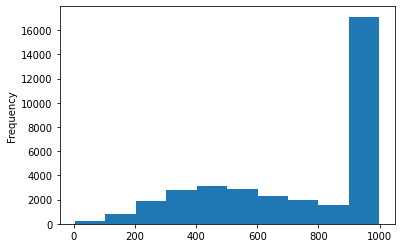

In [53]:
loci_df.QUAL.plot(kind="hist");

In [55]:
# this would not be zero if there was an error in the calculation
len(loci_df[loci_df.Fis == -9])

0

In [66]:
len(loci_df[loci_df.MEAN_DEPTH > 25]),len(loci_df[loci_df.MEAN_DEPTH >= 3])

(981, 34305)

In [67]:
len(loci_df[loci_df.QUAL >= 100]) - len(loci_df[loci_df.QUAL >= 200])

760

In [68]:
len(loci_df[loci_df.QUAL <  200]), len(loci_df[loci_df.QUAL < 250]), len(loci_df[loci_df.QUAL < 500])

(943, 1753, 8788)

In [69]:
 len(loci_df[loci_df.Fis <= -0.5]), len(loci_df[loci_df.MAF < 0.02])

(92, 87)

In [70]:
def filter_snps(df, imputed=False):
    if imputed:
        return df[(df.MAF >= 0.01) &  
                  (df.Fis > -0.5)]
    else:
        return df[(df.MEAN_DEPTH >= 3) & 
                  (df.MEAN_DEPTH < 25) & 
                  (df.QUAL >= 250) & 
                  (df.MAF >= 0.02) &  
                  (df.Fis > -0.5)]

In [71]:
loci_stage1 = filter_snps(loci_df)
loci_stage1.shape

(31652, 25)

In [72]:
with open(os.path.join(analysis_dir, "stage1_positions.txt"), "w") as o:
    for elem in loci_stage1.index:
        o.write("%s\n" % "\t".join(elem.split("-")))

In [73]:
!$vcftools --gzvcf $vcf_bad_remove_gz \
--remove-indels  \
--remove-filtered-all \
--recode \
--recode-INFO-all \
--positions {os.path.join(analysis_dir, "stage1_positions.txt")} \
--out {os.path.join(analysis_dir, "good_snps")}


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/PHHA/SNPcall/filtering/snps_indv_removed.recode.vcf.gz
	--recode-INFO-all
	--out /data/gpfs/assoc/denovo/PHHA/SNPcall/filtering/good_snps
	--positions /data/gpfs/assoc/denovo/PHHA/SNPcall/filtering/stage1_positions.txt
	--recode
	--remove-filtered-all
	--remove-indels

Using zlib version: 1.2.11
After filtering, kept 245 out of 245 Individuals
Outputting VCF file...
After filtering, kept 31652 out of a possible 34737 Sites
Run Time = 18.00 seconds


In [74]:
snps = os.path.join(analysis_dir, "good_snps.recode.vcf")
snps_gz = snps + ".gz"
!$bgzip -c {snps} > {snps_gz}
!$tabix {snps_gz}

# Make 012, see directory PCA_012 for results

In [76]:
!$vcftools --gzvcf {snps_gz} \
--out {snps_gz} \
--012


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/PHHA/SNPcall/filtering/good_snps.recode.vcf.gz
	--012
	--out /data/gpfs/assoc/denovo/PHHA/SNPcall/filtering/good_snps.recode.vcf.gz

Using zlib version: 1.2.11
After filtering, kept 245 out of 245 Individuals
Writing 012 matrix files ... Done.
After filtering, kept 31652 out of a possible 31652 Sites
Run Time = 3.00 seconds


# Get coverage per individual

In [77]:
!$vcftools --gzvcf {snps_gz} \
--out {snps_gz} \
--depth


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/PHHA/SNPcall/filtering/good_snps.recode.vcf.gz
	--depth
	--out /data/gpfs/assoc/denovo/PHHA/SNPcall/filtering/good_snps.recode.vcf.gz

Using zlib version: 1.2.11
After filtering, kept 245 out of 245 Individuals
Outputting Mean Depth by Individual
After filtering, kept 31652 out of a possible 31652 Sites
Run Time = 2.00 seconds


In [78]:
depth_file = os.path.join(analysis_dir, "good_snps.recode.vcf.gz.idepth")
depth_df = pd.read_csv(depth_file, sep="\t")
depth_df.head()

,INDV,N_SITES,MEAN_DEPTH
0,PH_AS_10,31652,9.84706
1,PH_AS_11,31652,5.68890
2,PH_AS_12,31652,10.21510
3,PH_AS_1,31652,10.24440
4,PH_AS_2,31652,9.31246


In [79]:
depth_df.MEAN_DEPTH.describe()

count    245.000000
mean       7.739640
std        2.023261
min        2.362980
25%        6.302410
50%        7.780460
75%        9.216040
max       17.353300
Name: MEAN_DEPTH, dtype: float64

## Estimate relatedness

#### Papers:
KING: 10.1093/bioinformatics/btq559  
Error in KING: 10.3389/fgene.2022.882268  

#### Relationship from papers:   
Duplicate/Clone/twin: r > 0.354    
Parent-offspring/full-sib: 0.177 < r < 0.354    
half-sib/cousin/2nd-degree: 0.0884 < r < 0.177  

In [84]:
!$vcftools --gzvcf {snps_gz} \
--out {snps_gz} \
--relatedness2


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/PHHA/SNPcall_tf/filtering/good_snps.recode.vcf.gz
	--out /data/gpfs/assoc/denovo/PHHA/SNPcall_tf/filtering/good_snps.recode.vcf.gz
	--relatedness2

Using zlib version: 1.2.11
After filtering, kept 245 out of 245 Individuals
Outputting Individual Relatedness
After filtering, kept 31652 out of a possible 31652 Sites
Run Time = 13.00 seconds


# Remove unnecessary files

In [80]:
!rm snps*

In [81]:
!rm *miss*

In [82]:
!rm *vcf

# Check 012 that PCA looks okay  

scp ggood_snps.recode.vcf.gz, good_snps.recode.vcf.gz.012, good_snps.recode.vcf.gz.012.indv over to your local computer and run same R markdown as in the ddocent_output, PCA_012 dir